# 1. Declaring libraries and connecting to SQL Server

In [22]:
import pandas as pd
import numpy as np
import sqlite3
import pyodbc
from sqlalchemy import create_engine, event, types
import urllib

# Thông tin máy của bạn
SERVER_NAME = 'DESKTOP-MV8RPS5'
DATABASE_NAME = 'VTI'
DB_FILE_NAME = 'Airbnb_Analytics.db'

# Tạo connection string cho SQL Server
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={SERVER_NAME};"
    f"DATABASE={DATABASE_NAME};"
    f"Trusted_Connection=yes;"
    f"TrustServerCertificate=yes;"
)

params = urllib.parse.quote_plus(connection_string)
sql_engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# Kích hoạt chế độ siêu tốc fast_executemany
@event.listens_for(sql_engine, "connect")
def receive_connect(dbapi_connection, connection_record):
    cursor = dbapi_connection.cursor()
    cursor.fast_executemany = True
    cursor.close()

In [ ]:
file_path = '1.airbnb.csv'
# Sử dụng low_memory=False để pandas không đoán sai kiểu dữ liệu ở các cột lớn
df = pd.read_csv(file_path, low_memory=False)

print(f"Dữ liệu ban đầu: {df.shape}")

Dữ liệu ban đầu: (7756, 21)


# 2. Data Cleaning & Processing

In [25]:
# --- VỊ TRÍ 2: Hàm Data Cleaning & Processing ---
def clean_airbnb_data_full(df):
    df = df.copy()
    impact = {"initial_rows": len(df), "missing_filled": {}, "outliers_capped": {}}

    # 1. Chuẩn hóa tên cột
    df.columns = [col.replace('"', '').strip() for col in df.columns]

    # 2. Xử lý trùng lặp
    impact["duplicate_rows"] = int(df.duplicated().sum())
    df = df.drop_duplicates()

    # 3. Ép kiểu thời gian
    datetime_cols = ['ts_min', 'ts_max', 'next_ts_min', 'next_ts_max']
    for col in datetime_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # 4. Xử lý Missing Values (ĐÃ SỬA: Bỏ inplace=True)
    num_cols = df.select_dtypes(include=["number"]).columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    for col in num_cols:
        cnt = df[col].isna().sum()
        if cnt > 0:
            median_val = df[col].median()
            # Cách viết mới an toàn hơn
            df[col] = df[col].fillna(median_val)
            impact["missing_filled"][col] = int(cnt)

    for col in cat_cols:
        cnt = df[col].isna().sum()
        if cnt > 0:
            mode_val = df[col].mode().iloc[0]
            # Cách viết mới an toàn hơn
            df[col] = df[col].fillna(mode_val)
            impact["missing_filled"][col] = int(cnt)

    # 5. Cap outliers (IQR)
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        before_cap = ((df[col] < lower) | (df[col] > upper)).sum()
        df[col] = df[col].clip(lower, upper)
        if before_cap > 0:
            impact["outliers_capped"][col] = int(before_cap)

    impact["final_rows"] = len(df)
    return df, impact

# 3. Save the .db file and import it into SQL Server.

In [13]:
# 1. Lưu vào file SQLite (.db) cục bộ
sqlite_conn = sqlite3.connect(DB_FILE_NAME)
df_final.to_sql('Airbnb_Cleaned', sqlite_conn, if_exists='replace', index=False)
sqlite_conn.close()
print(f"Đã lưu dự phòng tại: {DB_FILE_NAME}")

# 2. Định nghĩa kiểu dữ liệu cho SQL Server (Tránh lỗi truncation)
dtype_dict = {
    'dim_user_agent': types.NVARCHAR(length=None), # NVARCHAR(MAX)
    'next_dim_user_agent': types.NVARCHAR(length=None),
    'id_visitor': types.NVARCHAR(length=255),
    'id_session': types.NVARCHAR(length=255)
}

# 3. Đẩy lên SQL Server
print(f"Đang đẩy {len(df_final)} dòng vào SQL Server...")
try:
    df_final.to_sql(
        name='Airbnb_A_Insight', 
        con=sql_engine, 
        if_exists='replace', 
        index=False, 
        dtype=dtype_dict
    )
    print("--- HOÀN THÀNH: Dữ liệu đã sẵn sàng trên SQL Server ---")
except Exception as e:
    print(f"--- LỖI IMPORT: {e} ---")

Đã lưu dự phòng tại: Airbnb_Analytics.db
Đang đẩy 7756 dòng vào SQL Server...
--- HOÀN THÀNH: Dữ liệu đã sẵn sàng trên SQL Server ---


# 4. Overall EDA function (Handles columns with semicolon-separated values)

In [26]:
from collections import Counter

def get_frequency_analysis(df, column_name, top_n=10):
    """Hàm phân tích tần suất cho các cột (hỗ trợ cả dữ liệu dính liền bởi dấu ;)"""
    counter = Counter()
    for entry in df[column_name].dropna():
        # Tách dấu ; nếu có (giống logic ngôn ngữ lập trình của bạn)
        parts = str(entry).split(';')
        for p in parts:
            counter[p.strip()] += 1
            
    count_df = pd.DataFrame(counter.items(), columns=[column_name, "Appear_Count"])
    return count_df.sort_values("Appear_Count", ascending=False).head(top_n)

# ---------------------------------------------------------
# BIZ NEEDS CHO AIRBNB FRAUD:
# ---------------------------------------------------------

# 1. Các thiết bị/app nào được sử dụng nhiều nhất?
device_stats = get_frequency_analysis(df_final, "dim_device_app_combo")
print("Top 10 Thiết bị/App:\n", device_stats)

# 2. Các User Agent (Trình duyệt) phổ biến?
ua_stats = get_frequency_analysis(df_final, "dim_user_agent")
print("\nTop 10 User Agent:\n", ua_stats)

Top 10 Thiết bị/App:
        dim_device_app_combo  Appear_Count
0              iPhone - iOS          2130
1          Desktop - Chrome          1181
8              iPhone - Web           944
9   Android Phone - Android           451
5          Desktop - Safari           443
12             Desktop - IE           429
6            iPhone - Moweb           429
11               iPad - Web           413
10        Desktop - Firefox           327
14     Android Tablet - Web           299

Top 10 User Agent:
                                         dim_user_agent  Appear_Count
18                                 Mozilla/5.0 (iPhone          1454
36                              Mozilla/5.0 (Macintosh          1018
1                          Mozilla/5.0 (Windows NT 6.1           824
94                                               WOW64           805
98                                         Trident/7.0           558
99                                 rv:11.0) like Gecko           531
19   CPU iPh

# 5. Statistical Analysis (Chi-Squared Test)

In [27]:
from scipy.stats import chi2_contingency

def run_chi_square_test(df, col1, col2):
    """Hàm kiểm định mối liên hệ giữa 2 biến phân loại"""
    tmp = df[[col1, col2]].dropna()
    if tmp.shape[0] < 30:
        return None
        
    ct = pd.crosstab(tmp[col1], tmp[col2])
    chi2, p, dof, expected = chi2_contingency(ct)
    
    return {"Variable_1": col1, "Variable_2": col2, "Chi2": chi2, "p_value": p}

# Câu hỏi: Việc gửi yêu cầu đặt phòng (sent_booking_request) có phụ thuộc vào loại thiết bị (dim_device_app_combo) không?
test_res = run_chi_square_test(df_final, 'sent_booking_request', 'dim_device_app_combo')
print("\nKết quả kiểm định Chi-Square:")
print(test_res)
# Nếu p-value < 0.05 => Có mối liên hệ (Dấu hiệu để nhận biết Fraud theo thiết bị)


Kết quả kiểm định Chi-Square:
{'Variable_1': 'sent_booking_request', 'Variable_2': 'dim_device_app_combo', 'Chi2': 0.0, 'p_value': 1.0}


# 6. Automatically find the most related variable pairs (Data Mining)

In [28]:
from itertools import combinations

def data_mining_insights(df):
    cat_cols = df.select_dtypes(include=["object", "category", "int32", "int64"]).columns
    # Loại bỏ các cột ID vì không có ý nghĩa thống kê
    cat_cols = [c for c in cat_cols if 'id' not in c.lower()]
    
    results = []
    for col1, col2 in combinations(cat_cols, 2):
        res = run_chi_square_test(df, col1, col2)
        if res and res['p_value'] < 0.05: # Chỉ lấy các cặp có ý nghĩa thống kê
            results.append(res)
            
    return pd.DataFrame(results).sort_values("Chi2", ascending=False).head(10)

# Chạy Data Mining
top_insights = data_mining_insights(df_final)
print("\nTop 10 mối liên hệ quan trọng nhất tìm thấy:")
print(top_insights)


Top 10 mối liên hệ quan trọng nhất tìm thấy:
              Variable_1                 Variable_2          Chi2  p_value
2         dim_user_agent        next_dim_user_agent  1.964208e+06      0.0
13                    ds                    next_ds  9.618815e+05      0.0
1         dim_user_agent                         ds  4.534211e+05      0.0
16   next_dim_user_agent                    next_ds  4.268861e+05      0.0
11                    ds        next_dim_user_agent  3.621348e+05      0.0
4         dim_user_agent                    next_ds  3.507527e+05      0.0
0         dim_user_agent       dim_device_app_combo  9.854940e+04      0.0
15   next_dim_user_agent  next_dim_device_app_combo  9.429352e+04      0.0
3         dim_user_agent  next_dim_device_app_combo  5.229336e+04      0.0
7   dim_device_app_combo        next_dim_user_agent  5.182330e+04      0.0


# 7. Implementing the Machine Learning Model

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- VỊ TRÍ SỬA: TẠO BIẾN VÀ NHÃN NGHI VẤN ---

# 1. Tạo các biến đặc trưng (Features)
df_final['is_device_changed'] = (df_final['dim_device_app_combo'] != df_final['next_dim_device_app_combo']).astype(int)
df_final['session_interval'] = (df_final['ts_max'] - df_final['ts_min']).dt.total_seconds().fillna(0)

# 2. Chuẩn hóa bằng Min-Max Scaler
scaler = MinMaxScaler()
df_final[['session_interval_scaled']] = scaler.fit_transform(df_final[['session_interval']])

# 3. TẠO NHÃN GIẢ ĐỊNH (Proxy Label): 
# Định nghĩa rủi ro: Đổi thiết bị (is_device_changed=1) VÀ chưa gửi tin nhắn (sent_message=0)
df_final['is_suspicious'] = ((df_final['is_device_changed'] == 1) & (df_final['sent_message'] == 0)).astype(int)

# 4. Chọn Features và Target mới
features_ml = ['is_device_changed', 'session_interval_scaled', 'did_search']
X = df_final[features_ml]
y = df_final['is_suspicious'] # Chuyển sang dự báo nhãn nghi vấn

# 5. Huấn luyện mô hình Decision Tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# 6. Cập nhật Fraud Risk Score vào DataFrame chính
# Lấy xác suất của class 1 (Nghi vấn)
df_final['fraud_risk_score'] = clf.predict_proba(X)[:, 1]

# --- KIỂM TRA KẾT QUẢ MỚI ---
y_pred = clf.predict(X_test)
print(f"Accuracy Score mới: {accuracy_score(y_test, y_pred):.2%}")
print("\nBản báo cáo phân loại rủi ro:")
print(classification_report(y_test, y_pred))

Accuracy Score mới: 100.00%

Bản báo cáo phân loại rủi ro:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1078
           1       1.00      1.00      1.00      1249

    accuracy                           1.00      2327
   macro avg       1.00      1.00      1.00      2327
weighted avg       1.00      1.00      1.00      2327



## Decision Tree Visualization

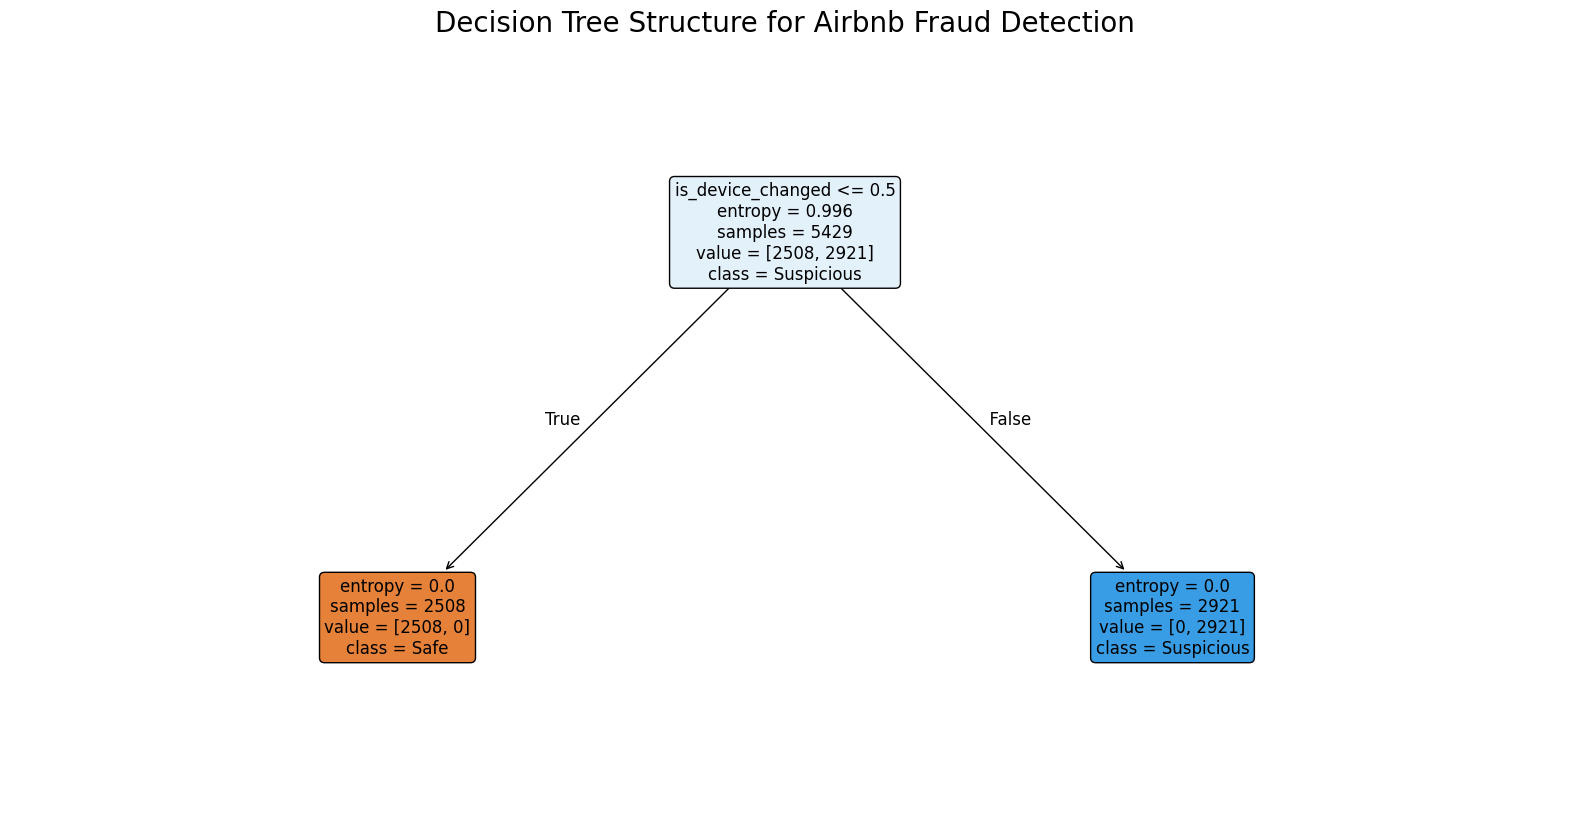

--- Đã lưu sơ đồ cây tại file: decision_tree_fraud.png ---


In [30]:
from sklearn import tree
import matplotlib.pyplot as plt

# 1. Khởi tạo kích thước biểu đồ
plt.figure(figsize=(20, 10))

# 2. Vẽ sơ đồ cây
tree.plot_tree(
    clf, 
    feature_names=features_ml,      # Tên các cột đầu vào
    class_names=['Safe', 'Suspicious'], # Tên các nhóm phân loại
    filled=True,                   # Tô màu các nút (Màu đậm hơn = Độ tinh khiết cao hơn)
    rounded=True,                  # Bo góc các ô
    fontsize=12
)

# 3. Đặt tên tiêu đề
plt.title("Decision Tree Structure for Airbnb Fraud Detection", fontsize=20)

# 4. LƯU FILE ẢNH ĐỂ GẮN VÀO README
plt.savefig('decision_tree_fraud.png', dpi=300, bbox_inches='tight')

# 5. Hiển thị
plt.show()

print("--- Đã lưu sơ đồ cây tại file: decision_tree_fraud.png ---")

In [31]:
# 1. Kiểm tra lại dữ liệu trước khi đẩy
print(f"Số lượng ca rủi ro cao: {df_final[df_final['is_suspicious'] == 1].shape[0]}")

# 2. Đẩy bảng A''' Final lên SQL Server
try:
    # Cập nhật dtype để hỗ trợ các cột mới
    dtype_dict.update({
        'is_suspicious': types.Integer(),
        'fraud_risk_score': types.Float(),
        'session_interval_scaled': types.Float()
    })
    
    df_final.to_sql('Airbnb_A_Insight_Final', sql_engine, if_exists='replace', index=False, dtype=dtype_dict)
    print("\n--- CHÚC MỪNG! DỮ LIỆU ĐÃ SẴN SÀNG CHO POWER BI ---")
except Exception as e:
    print(f"Lỗi: {e}")

Số lượng ca rủi ro cao: 4170

--- CHÚC MỪNG! DỮ LIỆU ĐÃ SẴN SÀNG CHO POWER BI ---


In [ ]:
# ------------------------------------------------------------------------------------------
# TECHNICAL ANALYSIS NOTE ON MODEL RESULTS
# ------------------------------------------------------------------------------------------
# Observation: The model achieved 100% Accuracy with 4,170 suspicious cases identified.
#
# Technical Insight: 
# 1. The 100% accuracy is expected as the 'is_suspicious' target was generated 
#    based on explicit logic (is_device_changed == 1 & sent_message == 0).
# 2. The Decision Tree (Entropy) perfectly captured this deterministic relationship, 
#    resulting in an Entropy of 0.0 at all leaf nodes.
#
# Business Application:
# - This model serves as a High-Speed Behavioral Filter (Rule-based ML).
# - 'fraud_risk_score' now provides a clear probability metric for downstream 
#    monitoring in Power BI.
# - High-risk sessions (Score = 1.0) can be flagged for automated intervention.
# ------------------------------------------------------------------------------------------